## Detecting Twitter Bots

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [48]:
filepath = '/home/damion/Desktop/kaggle_data/'
file= 'training_data_5.csv'

training_data = pd.read_csv(file)
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]


### Data Analysis

#### Identifying Missing data

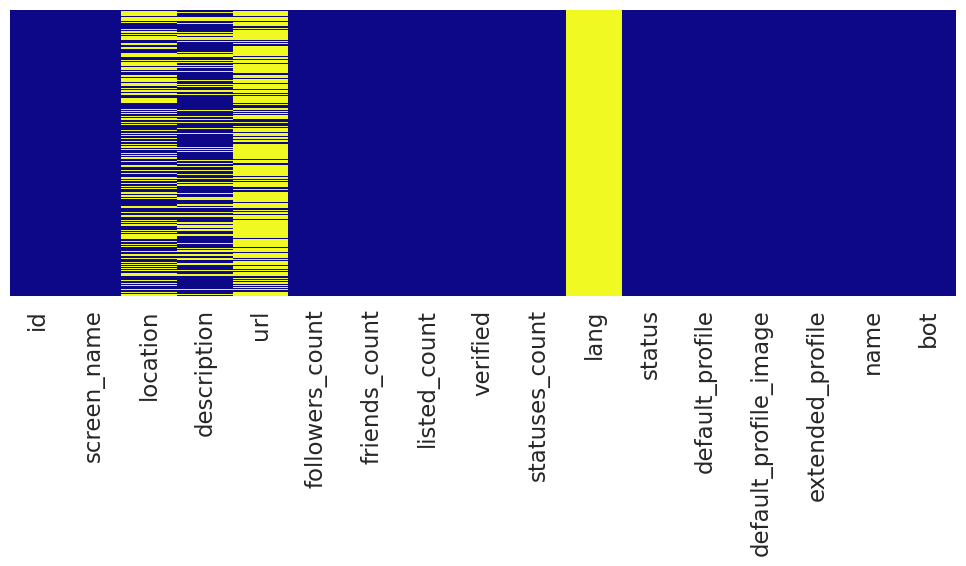

In [49]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

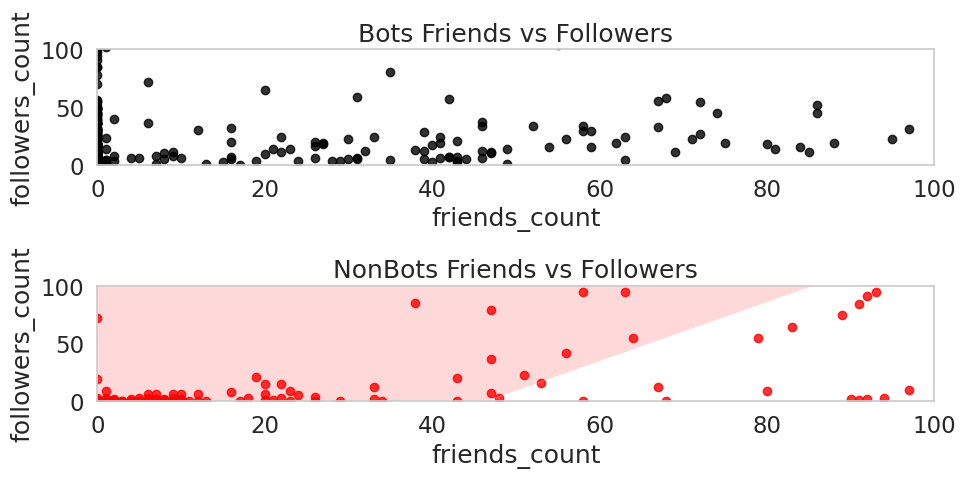

In [50]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(x=bots.friends_count, y=bots.followers_count, color='black', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(x=nonbots.friends_count, y=nonbots.followers_count, color='red', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

#### Identifying Imbalance in the data

In [51]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(527, 18)

In [52]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

In [53]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(629, 21)

In [54]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1110, 21)

In [55]:
df = pd.concat([bots, nonbots])

df.shape

(1739, 21)

### Feature Independence using Spearman correlation

In [56]:

df.corr(method='spearman')

,id,followers_count,friends_count,listed_count,verified,statuses_count,lang,default_profile,default_profile_image,extended_profile,bot,friends_by_followers,screen_name_binary,location_binary,verified_binary
id,1.000000,-0.244076,-0.212007,-0.333284,-0.163806,-0.328482,NaN,0.435437,0.160958,0.086276,-0.146949,0.055458,0.151104,-0.131872,-0.137827
followers_count,-0.244076,1.000000,0.748688,0.710411,0.261205,0.729357,NaN,-0.370414,-0.249056,0.211093,-0.358879,-0.148635,0.363363,0.168336,-0.353513
friends_count,-0.212007,0.748688,1.000000,0.566341,0.170128,0.543590,NaN,-0.270969,-0.179629,0.240099,-0.401510,0.415614,0.393151,0.176023,-0.389312
listed_count,-0.333284,0.710411,0.566341,1.000000,0.256117,0.642539,NaN,-0.366683,-0.190511,0.058037,-0.219450,-0.060444,0.233546,0.165109,-0.217449
verified,-0.163806,0.261205,0.170128,0.256117,1.000000,0.170297,NaN,-0.109342,-0.028897,-0.047343,0.028067,-0.155247,-0.029710,0.026772,0.064671
statuses_count,-0.328482,0.729357,0.543590,0.642539,0.170297,1.000000,NaN,-0.396978,-0.259885,0.224563,-0.241989,-0.094301,0.250117,0.130642,-0.258086
lang,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default_profile,0.435437,-0.370414,-0.270969,-0.366683,-0.109342,-0.396978,NaN,1.000000,0.162186,-0.065627,0.111706,0.054184,-0.109001,-0.084235,0.110701
default_profile_image,0.160958,-0.249056,-0.179629,-0.190511,-0.028897,-0.259885,NaN,0.162186,1.000000,-0.062663,0.005777,-0.002900,-0.007496,-0.073089,0.004708
extended_profile,0.086276,0.211093,0.240099,0.058037,-0.047343,0.224563,NaN,-0.065627,-0.062663,1.000000,-0.375985,0.137397,0.370250,0.043193,-0.373892


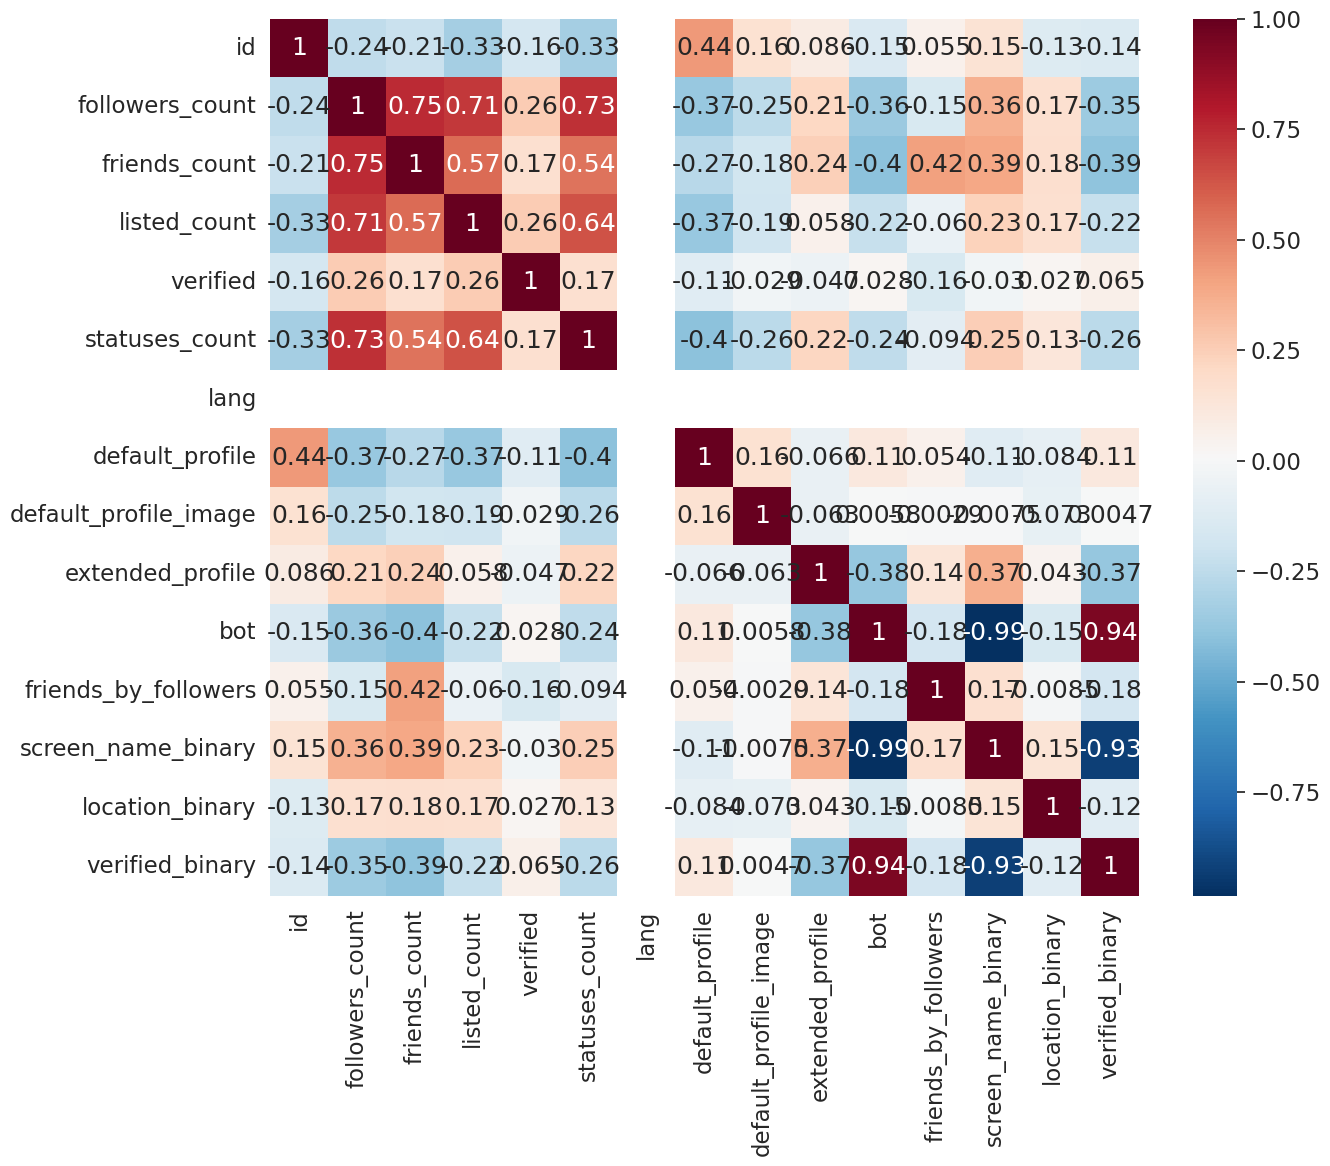

In [57]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(method='spearman'), cmap='RdBu_r', annot=True)
plt.tight_layout()
plt.show()

Result:
- There is no correlation between **id, statuses_count, default_profile, default_profile_image** and target variable.
- There is strong correlation between **verified, listed_count, friends_count, followers_count** and target variable.
- We cannot perform correlation for categorical attributes. So we will take **screen_name, name, description, status** into feature engineering. While use **verified, listed_count** for feature extraction.

#### Performing Feature Engineering

In [58]:
filepath = '/home/damion/Desktop/kaggle_data/'
file= open('training_data_5.csv', mode='r', encoding='utf-8', errors='ignore')

training_data = pd.read_csv(file)

bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

#### Performing Feature Extraction

In [59]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

## Implementing Different Models

#### Decision Tree Classifier

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Training Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Training Accuracy: 0.85127
Test Accuracy: 0.84483


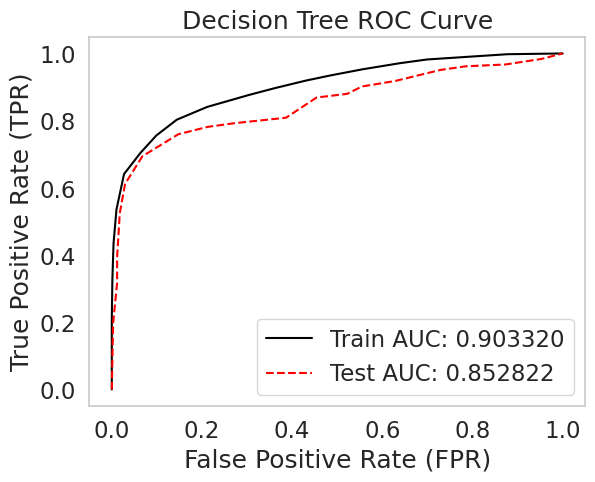

In [61]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='black', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

Result: Decision Tree gives very good performance and generalizes well. But it may be overfitting as AUC is 0.937, so we will try other models.

#### Random Forest Classifier

In [62]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.78882
Test Accuracy: 0.78544


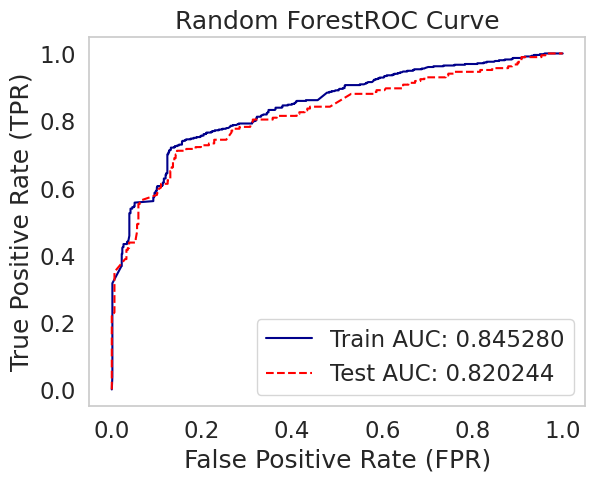

In [63]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

### Thank you.